In [146]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import hvplot.pandas
import locale
locale.setlocale( locale.LC_ALL, 'en_CA.UTF-8' )
%matplotlib inline
import yfinance as yf

In [141]:
user_portfolio_name = ["MSFT", "AAPL", "AMZN","GOOGL","FB", "V", "JPM"]
# user_portfolio_name = ["MSFT"]
#Display Benchmark info
benchmark=["SPY"]

list_of_tickers=benchmark+user_portfolio_name

data = yf.download(
        tickers = list_of_tickers,
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        period = "30y",
        interval = "1d",
        group_by = 'ticker',

        # adjust all OHLC automatically, adjusted for stock splits
        auto_adjust = True,
        prepost = True,
        threads = True,
        proxy = None
    )
data.head()

[*********************100%***********************]  8 of 8 completed


FB                       AMZN                        ...  \
           Open High Low Close Volume Open High Low Close Volume  ...   
Date                                                              ...   
1990-05-14  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   
1990-05-15  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   
1990-05-16  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   
1990-05-17  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   
1990-05-18  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   

                MSFT                                               AAPL  \
                Open      High       Low     Close     Volume      Open   
Date                                                                      
1990-05-14  0.590366  0.592594  0.583683  0.585910   47232000  1.238803   
1990-05-15  0.583682  0.585910  0.572543  0.576999   54118400  1.198958   
1990-05-16  0.574771  0.576999  0.565860  0.576999   38553600  1.209825   
1990-05-17  0.576999  0.581455  0.572543  0.576999   41731200  1.209825   
1990-05-18  0.575885  0.617099  0.574771  0.608188  101820800  1.195336   

                                                    
                High       Low     Close    Volume  
Date                                                
1990-05-14  1.238803  1.195336  1.209825  56596400  
1990-05-15  1.217069  1.188092  1.209825  37346400  
1990-05-16  1.209825  1.188092  1.206203  21826000  
1990-05-17  1.224314  1.188092  1.202580  38396400  
1990-05-18  1.202581  1.144625  1.151870  64615600  

[5 rows x 40 columns]

In [142]:
df_yf = data.sort_index()
df_yf.drop(columns=['Open', 'High', 'Low', 'Volume'], level=1, inplace=True)
df_yf = df_yf.droplevel(axis=1, level=1)
df_yf.index = df_yf.index.date
df_yf.dropna(inplace=True)
df_yf.head()

,FB,AMZN,V,GOOGL,SPY,JPM,MSFT,AAPL
2012-05-18,38.230000,213.850006,24.946079,300.500488,110.416977,26.767208,24.394806,65.592659
2012-05-21,34.029999,218.110001,25.738934,307.362366,112.314842,25.983931,24.794863,69.414101
2012-05-22,31.000000,215.330002,26.219515,300.700714,112.510582,27.182817,24.803186,68.881065
2012-05-23,32.000000,217.279999,26.392260,305.035034,112.570198,27.382633,24.261457,70.561768
2012-05-24,33.029999,215.240005,26.525141,302.132141,112.791443,27.150858,24.228115,69.913734


In [147]:
df_yf.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [42]:
yf_daily_returns = df_yf.pct_change().dropna()
yf_daily_returns.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [139]:
means = {}
daily_returns = df_yf.pct_change()
daily_returns.dropna(inplace=True)

for stock in list_of_tickers:
#     print(stock)
    means[stock] = daily_returns.mean()[stock]#,[daily_returns.mean()[stock]]
#     print(f'{stock} mean: {means[stock]}')
means

{'SPY': 0.0005396397574629934,
 'MSFT': 0.0011427264437671063,
 'AAPL': 0.0009287564005639738,
 'AMZN': 0.001380788065994438,
 'GOOGL': 0.0008865500985032975,
 'FB': 0.0011286396769122893,
 'V': 0.001115700940619467,
 'JPM': 0.0007513887872967639}

## Run Monte Carlo Simulation for Benchmark

In [69]:
yf_daily_returns.loc[:,benchmark]

,SPY
2012-05-21,0.017188
2012-05-22,0.001743
2012-05-23,0.000530
2012-05-24,0.001965
2012-05-25,-0.003244
...,...
2020-05-04,0.002758
2020-05-05,0.009239
2020-05-06,-0.006779
2020-05-07,0.012067


In [101]:
# Run the Monte Carlo Simulation
number_simulations = 500 # columns
number_records = 252 * 30 # rows
monte_carlo = pd.DataFrame()
simulated_price_df = pd.DataFrame()
benchmark_last_price = df_yf.loc[:,benchmark].iloc[-1,0]
print(benchmark_last_price)
avg_daily_return_benchmark = yf_daily_returns.mean()['SPY']
std_dev_daily_return_benchmark = yf_daily_returns.std()['SPY']
print(avg_daily_return_benchmark)
print(std_dev_daily_return_benchmark)

292.44000244140625
0.0005396397574629934
0.010342514438189745


In [149]:
number_simulations = 10 # columns
number_records = 10# rows

# Set last closing prices of `JNJ` and `MU`
benchmark_last_price = df_yf.loc[:,benchmark].iloc[-1,0]
# mu_last_price = df['MU']['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `JNJ` and `MU`
    simulated_benchmark_prices = [benchmark_last_price]
#     simulated_mu_prices = [mu_last_price]
    
    # Simulate the returns for 252 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_benchmark_price = simulated_benchmark_prices[-1] * (1 + np.random.normal(avg_daily_return_benchmark, std_dev_daily_return_benchmark))
#         simulated_mu_price = simulated_mu_prices[-1] * (1 + np.random.normal(avg_daily_return_mu, std_dev_daily_return_mu))
        
        # Append the simulated price to the list
        simulated_benchmark_prices.append(simulated_benchmark_price)
#         simulated_mu_prices.append(simulated_mu_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_benchmark_prices)
#     simulated_price_df["MU prices"] = pd.Series(simulated_mu_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% JNJ; 40% MU)
    b_weights = [1.00]
#     p_weights = [1/7,1/7,1/7,1/7,1/7,1/7,1/7]
    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[f'T{n}'] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004112,1.011946,1.001252,0.999324,1.006247,0.997684,1.015097,0.999813,0.986943,1.010319
2,1.005413,1.025403,1.001431,0.999109,1.009137,1.002017,1.012137,1.000715,0.985723,1.008662
3,1.013755,1.015006,0.992379,0.980116,1.004236,1.012252,1.009975,1.002260,0.986461,1.000047
4,1.018474,1.024675,0.998681,0.973851,0.991218,1.013757,1.009415,1.012704,0.996565,0.995378


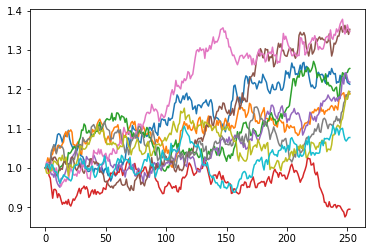

In [151]:
portfolio_cumulative_returns.plot(legend=None,);

## Run portfolio Monte Carlo Simulation

In [60]:
#TODO Enter users weghts variable
weights = [1/7,1/7,1/7,1/7,1/7,1/7,1/7]
portfolio_returns = yf_daily_returns.drop(benchmark,axis=1)
weighted_portfolio_returns=portfolio_returns.dot(weights)
# yf_daily_returns_df2=yf_daily_returns.dot(weights)
# yf_daily_returns_df2.head()
weighted_portfolio_returns#.tail()

2012-05-21    0.001439
2012-05-22   -0.009427
2012-05-23    0.010318
2012-05-24   -0.000101
2012-05-25   -0.012543
                ...   
2020-05-04    0.008875
2020-05-05    0.009510
2020-05-06    0.003114
2020-05-07    0.012381
2020-05-08    0.011460
Length: 2005, dtype: float64

In [ ]:
number_simulations = 500 # columns
number_records = 252 * 30 # rows

# Set last closing prices of `JNJ` and `MU`
benchmark_last_price = df_yf.loc[:,benchmark].iloc[-1,0]
# mu_last_price = df['MU']['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `JNJ` and `MU`
    simulated_benchmark_prices = [benchmark_last_price]
#     simulated_mu_prices = [mu_last_price]
    
    # Simulate the returns for 252 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_benchmark_price = simulated_benchmark_prices[-1] * (1 + np.random.normal(avg_daily_return_benchmark, std_dev_daily_return_benchmark))
#         simulated_mu_price = simulated_mu_prices[-1] * (1 + np.random.normal(avg_daily_return_mu, std_dev_daily_return_mu))
        
        # Append the simulated price to the list
        simulated_benchmark_prices.append(simulated_benchmark_price)
#         simulated_mu_prices.append(simulated_mu_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_benchmark_prices)
#     simulated_price_df["MU prices"] = pd.Series(simulated_mu_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% JNJ; 40% MU)
    b_weights = [1.00]
#     p_weights = [1/7,1/7,1/7,1/7,1/7,1/7,1/7]
    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[f'T{n}'] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

# Enter desired parameters

Enter ticker symbols, weights

In [6]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [148]:
# stock1= input("stock:")
# print(stock1)

datetime.now()

datetime.datetime(2020, 5, 9, 1, 23, 43, 287661)

In [243]:
#using adjusted close might be better
aapl = api.alpha_vantage.historic_quotes(['spy'], adjusted=True, output_format='pandas')
aapl.tail()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2000-05-12,141.8125,143.4687,141.6250,142.8125,97.8034,5960800.0,0.0,1.0
2000-05-11,140.1250,141.5000,139.1250,141.2812,96.7547,7091100.0,0.0,1.0
2000-05-10,140.5000,140.9687,137.7500,138.1250,94.5932,10293900.0,0.0,1.0
2000-05-09,143.0625,143.4062,140.2656,141.3125,96.7761,5620300.0,0.0,1.0
2000-05-08,142.7500,143.3750,141.8437,142.4531,97.5572,5064100.0,0.0,1.0


In [7]:
# list_of_tickers = [stock1]
list_of_tickers = ["ADM", "AGG"]
# TODO test with other variables: '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('1990-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2020-05-01', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data using alpaca api
df = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
df.tail()
# df.columns


ADM                                   AGG  \
                            open   high    low  close   volume    open   
2020-04-27 00:00:00-04:00  35.87  36.71  35.81  36.55  1610349  117.21   
2020-04-28 00:00:00-04:00  37.17  37.31  36.31  37.18  2298554  117.27   
2020-04-29 00:00:00-04:00  37.90  38.60  37.64  38.43  2974932  117.29   
2020-04-30 00:00:00-04:00  38.40  38.71  37.05  37.12  3244053  117.38   
2020-05-01 00:00:00-04:00  36.66  36.93  34.94  35.12  2351702  116.97   

                                                                 
                               high       low   close    volume  
2020-04-27 00:00:00-04:00  117.3600  116.8200  116.84   6707494  
2020-04-28 00:00:00-04:00  117.4500  117.1200  117.25  10729690  
2020-04-29 00:00:00-04:00  117.4800  117.2000  117.43   9036494  
2020-04-30 00:00:00-04:00  117.4900  117.0650  117.15  13756340  
2020-05-01 00:00:00-04:00  117.0998  116.6775  116.90  11778582

In [9]:
df = df.sort_index()
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df = df.droplevel(axis=1, level=1)
df.index = df.index.date
df.dropna(inplace=True)
df.tail()

,ADM,AGG
2020-04-27,36.55,116.84
2020-04-28,37.18,117.25
2020-04-29,38.43,117.43
2020-04-30,37.12,117.15
2020-05-01,35.12,116.90


In [151]:
# df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [71]:
user_portfolio_name = ["MSFT", "AAPL", "AMZN","GOOGL","FB", "V", "JPM"]
# user_portfolio_name = ["MSFT"]
#Display Benchmark info
benchmark=["SPY"]

list_of_tickers=benchmark+user_portfolio_name

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
#TODO Introduce today variable & 30 yrs
start_date = pd.Timestamp('1990-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2020-05-01', tz='America/New_York').isoformat()


# Get 1 year's worth of historical data using alpaca api
df = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
df.head()
# df.head()
# df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

NameError: name 'api' is not defined

In [77]:
df = df.sort_index()
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df = df.droplevel(axis=1, level=1)
df.index = df.index.date
df.dropna(inplace=True)
df.head()

,ADM,AMZN,FB,GOOGL,JPM,MSFT,SPY,V
2012-05-18,27.18,213.78,38.1820,300.495,33.4900,29.27,129.82,28.160
2012-05-21,32.19,218.26,34.0255,307.237,32.5250,29.75,131.95,29.043
2012-05-22,32.17,215.61,31.1100,300.700,34.0100,29.77,132.07,29.600
2012-05-23,31.93,217.28,32.0000,305.025,34.2724,29.10,132.26,29.803
2012-05-24,27.42,215.24,33.0200,302.207,33.9800,29.08,132.50,29.943


In [78]:
##TODO drop level is not working, need to sink header from list of tickers compared to the order of socks received. headers incorrect name

# df = df.droplevel(axis=1, level=0)

# # Use the drop function to drop extra columns
# df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# # Since this is daily data, we can keep only the date (remove the time) component of the data
# df.index = df.index.date

# columns= list_of_tickers
# df.columns=columns
cleaned_df=df
cleaned_df
# historic_close=df
# historic_close.head()

,ADM,AMZN,FB,GOOGL,JPM,MSFT,SPY,V
2012-05-18,27.18,213.78,38.1820,300.495,33.4900,29.27,129.82,28.160
2012-05-21,32.19,218.26,34.0255,307.237,32.5250,29.75,131.95,29.043
2012-05-22,32.17,215.61,31.1100,300.700,34.0100,29.77,132.07,29.600
2012-05-23,31.93,217.28,32.0000,305.025,34.2724,29.10,132.26,29.803
2012-05-24,27.42,215.24,33.0200,302.207,33.9800,29.08,132.50,29.943
...,...,...,...,...,...,...,...,...
2020-04-27,36.55,2376.82,187.5400,1270.860,94.3700,174.03,287.11,171.760
2020-04-28,37.18,2314.08,182.8600,1232.310,95.2801,169.79,285.77,171.280
2020-04-29,38.43,2371.88,193.9900,1341.221,97.7900,177.30,293.19,181.860
2020-04-30,37.12,2471.50,204.7100,1346.860,95.7600,179.22,290.39,178.630


In [79]:
#TODO change to hvplot, Define function to create plot
cleaned_df.hvplot()
# cleaned_df.plot(label="test",kind='line',title='Historic Pricing', figsize=[20,2])
# df3.plot(label="test",kind='line',title='Historic Returns', figsize=[20,2])

:NdOverlay   [Variable]
   :Curve   [index]   (value)

# Select year and month of historical data

In [ ]:
user_sd= 2015
user_ed= 2019

cleaned_df

In [80]:
#TODO Remove NsN
#TODO calculate user's portfolio cumulative return
daily_returns = cleaned_df.pct_change()
daily_returns

,ADM,AMZN,FB,GOOGL,JPM,MSFT,SPY,V
2012-05-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-21,0.184327,0.020956,-0.108860,0.022436,-0.028815,0.016399,0.016407,0.031357
2012-05-22,-0.000621,-0.012141,-0.085686,-0.021277,0.045657,0.000672,0.000909,0.019178
2012-05-23,-0.007460,0.007745,0.028608,0.014383,0.007715,-0.022506,0.001439,0.006858
2012-05-24,-0.141246,-0.009389,0.031875,-0.009239,-0.008532,-0.000687,0.001815,0.004698
...,...,...,...,...,...,...,...,...
2020-04-27,0.015842,-0.013768,-0.013467,-0.004504,0.040463,-0.002922,0.014380,0.026966
2020-04-28,0.017237,-0.026397,-0.024955,-0.030334,0.009644,-0.024364,-0.004667,-0.002795
2020-04-29,0.033620,0.024978,0.060866,0.088380,0.026342,0.044231,0.025965,0.061770
2020-04-30,-0.034088,0.042000,0.055261,0.004204,-0.020759,0.010829,-0.009550,-0.017761


In [81]:
daily_returns.dropna()

,ADM,AMZN,FB,GOOGL,JPM,MSFT,SPY,V
2012-05-21,0.184327,0.020956,-0.108860,0.022436,-0.028815,0.016399,0.016407,0.031357
2012-05-22,-0.000621,-0.012141,-0.085686,-0.021277,0.045657,0.000672,0.000909,0.019178
2012-05-23,-0.007460,0.007745,0.028608,0.014383,0.007715,-0.022506,0.001439,0.006858
2012-05-24,-0.141246,-0.009389,0.031875,-0.009239,-0.008532,-0.000687,0.001815,0.004698
2012-05-25,0.004376,-0.010918,-0.033995,-0.020635,-0.014715,-0.001032,-0.002717,-0.003440
...,...,...,...,...,...,...,...,...
2020-04-27,0.015842,-0.013768,-0.013467,-0.004504,0.040463,-0.002922,0.014380,0.026966
2020-04-28,0.017237,-0.026397,-0.024955,-0.030334,0.009644,-0.024364,-0.004667,-0.002795
2020-04-29,0.033620,0.024978,0.060866,0.088380,0.026342,0.044231,0.025965,0.061770
2020-04-30,-0.034088,0.042000,0.055261,0.004204,-0.020759,0.010829,-0.009550,-0.017761


In [82]:
#TODO figure out what caused "SPY" swing, 
daily_returns.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [232]:
#Why only min only to 2008?
print(df.index.min())
print(df.index.max())

2008-01-02
2020-05-01


In [73]:
#Asign weigh distribution of portfolio with a desired PV.

initial_investment = 20000
#TODO To find weight distribution have to either drop all NANs or calculate proportional weight based on available investment
#proportional weight =sum(row)
# weights = [1/7,1/7,1/7,1/7,1/7,1/7,1/7]
weights = [1/8,1/8,1/8,1/8,1/8,1/8,1/8,1/8]
# df4=daily_returns.dot(weights)
daily_returns.isnull().sum()

AAPL     1
AMZN     1
FB       1
GOOGL    1
JPM      1
MSFT     1
SPY      1
V        1
dtype: int64

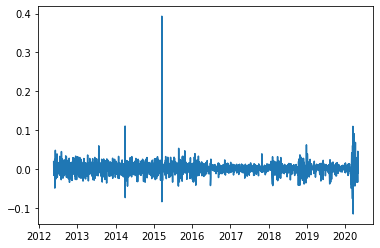

In [83]:
#TODO we might have to clean NANs
df2=daily_returns.dot(weights)
df2.plot()

In [ ]:
df.hvplot.line(x='Year', y='Violent Crime rate')

In [115]:
df.hvplot()

AttributeError: 'DataFrame' object has no attribute 'hvplot'

# Monte Carlo Simulation

In [70]:
# Calculate the daily roi for the stocks
#Data Load
#Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
df = df.droplevel(axis=1, level=0)
# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

# columns=["AGG","SPY"]
# df.columns=columns

historic_close=df
# historic_close.head()

df_roi=historic_close.pct_change()
df_roi.head()


NameError: name 'df' is not defined

In [41]:
## Calculate volatility
#Average historic returns
avg_daily_return_AGG = df_roi.mean()['AGG']
avg_daily_return_SPY = df_roi.mean()['SPY']
std_dev_daily_return_AGG = df_roi.std()['AGG']
std_dev_daily_return_SPY = df_roi.std()['SPY']

print(f'The standard deviation for AGG is:{std_dev_daily_return_AGG}')
print(f'The standard deviation for SPY is:{std_dev_daily_return_SPY}')

The standard deviation for AGG is:0.008486380070068245
The standard deviation for SPY is:0.030902726500259218


In [42]:
# Save the last day's closing price
agg_last_price = historic_close['AGG'][-1]
spy_last_price = historic_close['SPY'][-1]
print(f'Last closing price for for AGG is:{locale.currency(agg_last_price)}')
print(f'Last closing price for for SPY is:{locale.currency(spy_last_price)}')

Last closing price for for AGG is:$116.73
Last closing price for for SPY is:$287.70


In [86]:
# Setup the Monte Carlo Parameters
#number of simulations X n # of days
number_simulations = 500 # columns
number_records = 252 * 30 # rows
monte_carlo = pd.DataFrame()
simulated_price_df = pd.DataFrame()

In [87]:
# Run the Monte Carlo Simulation

# set # of simulations with defined variables
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price as PV.
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252 * i days variable predefined.
    #Using normal distribution on random
    for i in range(number_records):
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_AGG, std_dev_daily_return_AGG))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_SPY, std_dev_daily_return_SPY))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
        
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]
    
     # Use the `dot` Numpy function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    #columns header WIP
    monte_carlo[f"Simulation{n}"] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print head of DataFrame
monte_carlo.head()

NameError: name 'agg_last_price' is not defined

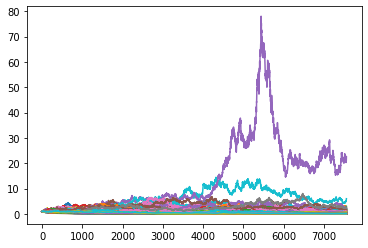

In [45]:
# Visualize the Simulation
monte_carlo.plot(legend=None,);

In [64]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = monte_carlo.iloc[-1, :]
ending_cumulative_returns.head()

0    0.125370
1    0.195310
2    0.232429
3    0.706620
4    0.122965
Name: 7560, dtype: float64

In [65]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
#20 yrs hardcoded for now
ending_cumulative_returns = monte_carlo.iloc[-2520, :]
ending_cumulative_returns.head()

0    0.624795
1    0.074677
2    0.561163
3    0.261969
4    0.677228
Name: 5041, dtype: float64

In [66]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    0.027793
0.95    1.784260
Name: 5041, dtype: float64

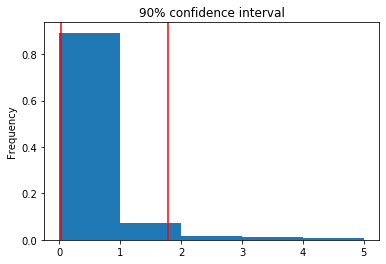

In [67]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=[0,1,2,3,4,5],title="90% confidence interval")
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [68]:
# confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
print(f'Expected cumulative return at yr 30 for 10th percentile is: {confidence_interval.iloc[0]}')
print(f'Expected cumulative return at yr 30 for 10th percentile is: {ending_cumulative_returns.median()}')
print(f'Expected cumulative return at yr 30 for 90th percentile is: {confidence_interval.iloc[1]}')


Expected cumulative return at yr 30 for 10th percentile is: 0.02779335190234906
Expected cumulative return at yr 30 for 10th percentile is: 0.21580133055241146
Expected cumulative return at yr 30 for 90th percentile is: 1.784259655077452


In [96]:
confidence_interval.iloc[1]

1.784259655077452

In [ ]:
ending_cumulative_returns.median()

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [110]:
initial_investment = 20000

# Calculate cumulative profit/loss of lower and upper bound
#weights are hardcoaded for now
cumulative_pnl_lower_bound = initial_investment *     ((confidence_interval.iloc[0] - 1)/1) #(.4*agg_last_price+.6*spy_last_price)) / (.4*agg_last_price+.6*spy_last_price))
cumulative_pnl_mid_bound = initial_investment *     (((confidence_interval.iloc[1] -confidence_interval.iloc[0]) - 1)/1) #(.4*agg_last_price+.6*spy_last_price)) / (.4*agg_last_price+.6*spy_last_price))
cumulative_pnl_upper_bound = initial_investment *     ((confidence_interval.iloc[1] - 1)/1) #(.4*agg_last_price+.6*spy_last_price)) / (.4*agg_last_price+.6*spy_last_price))

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_mid_bound = initial_investment + cumulative_pnl_mid_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound
print(locale.currency(ending_investment_lower_bound,grouping=True))
print(locale.currency(ending_investment_mid_bound,grouping=True))
print(locale.currency(ending_investment_upper_bound,grouping=True))
# Print the results
print(f"There is a 90% chance that an initial investment of $20,000 in this portfolio"
      f" over the next 30 trading years will end within in the range of"
      f" {locale.currency(ending_investment_lower_bound,grouping=True)} for the 10th percentile, {locale.currency(ending_investment_mid_bound,grouping=True)} for the 50th percentile, and {locale.currency(ending_investment_upper_bound,grouping=True)} for the 90th percentile")

$555.87
$35,129.33
$35,685.19
There is a 90% chance that an initial investment of $20,000 in this portfolio over the next 30 trading years will end within in the range of $555.87 for the 10th percentile, $35,129.33 for the 50th percentile, and $35,685.19 for the 90th percentile


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [103]:
#projected annual income before taxes =$7,389?
.04 * (initial_investment * ending_cumulative_returns.quantile(.1))


35.49989544522024

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [ ]:
# YOUR CODE HERE

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE